## Create Multi-Layer NN model using tensorflow

So I can adjust the parameters as I want...

In [1]:
import sys
sys.path.append("./src") # append to system path

from sklearn import cross_validation
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib

import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.patches import Rectangle
style.use('ggplot')

/home/runsheng/anaconda2/envs/tensorflow/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def load_lcia_data(descs_p, target_p):
    X = pd.read_csv(descs_p,header=0,index_col=None)
    X = X.fillna(0)
    y = pd.read_csv(target_p,header=0,index_col=None)
    return X.values,y.values

def mre(true_y,pred_y):
    ## Note: does not handle mix 1d representation
    #if _is_1d(y_true): 
    #    y_true, y_pred = _check_1d_array(y_true, y_pred)

    return np.mean(np.abs((true_y - pred_y) / true_y)) * 100

### Load Training data
The training data has 156 chemicals now. The rest 10 chemicals are test data
We also split the training and validation data here
We use smaller set (10%) to be the valdiation set (16 chemicals), as the limited size of training chemicals.

In [3]:
descs_p = '../data/descs/train/descs_Mar08_3839_train.csv'
target_p = '../data/target/train/CED_train.csv'
X,y = load_lcia_data(descs_p, target_p)

trn_X, val_X, trn_y, val_y = cross_validation.train_test_split(
    X, y, test_size=0.1, random_state=42)

In [4]:
print trn_X.shape, trn_y.shape

(140, 3839) (140, 1)


### Load Testing data

In [5]:
descs_tst = '../data/descs/test/descs_Mar08_3839_test.csv'
target_tst = '../data/target/test/CED_test.csv'
tst_X,tst_y = load_lcia_data(descs_tst, target_tst)

### Data Preprocessing
Normalization + PCA or Just Normalization

### Just Scaler

In [6]:
## Standard Scaler
this_scaler = StandardScaler()
trn_X = this_scaler.fit_transform(trn_X)
val_X = this_scaler.transform(val_X)
tst_X = this_scaler.transform(tst_X)

In [7]:
print trn_X.shape
print tst_X.shape
print np.mean(trn_X,0),np.std(trn_X,0)

(140, 3839)
(10, 3839)
[  8.94522551e-16  -4.85474756e-16  -3.96508223e-17 ...,   0.00000000e+00
  -6.97854473e-17   4.83740032e-17] [ 1.  1.  1. ...,  0.  1.  1.]


##  PCA

In [8]:
### PCA, don't run them together
# normalize the data first
pca = PCA(n_components = 60)

trn_X = pca.fit_transform(trn_X)
val_X = pca.transform(val_X)
tst_X = pca.transform(tst_X)

In [9]:
print trn_X.shape, tst_X.shape
print(reduce(lambda x,y:x+y,pca.explained_variance_ratio_))

(140, 60) (10, 60)
0.959537194246


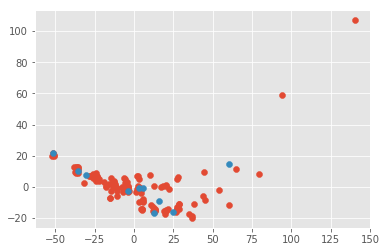

In [10]:
plt.scatter(trn_X[:,0],trn_X[:,1])
plt.scatter(tst_X[:,0],tst_X[:,1])
plt.show()

### Save the Scaler and PCA object

In [11]:
joblib.dump(this_scaler, '../nets/CED/scaler.pkl') 
joblib.dump(pca, '../nets/CED/pca.pkl') 

['../nets/CED/pca.pkl']

### Build the model

In [12]:
def init_weights(shape):
    weights = tf.truncated_normal(shape,stddev = 0.1)
    return tf.Variable(weights)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

num_descs = trn_X.shape[1]
num_target = trn_y.shape[1]

print num_descs,num_target

60 1


In [13]:
##### 
##Define model structure

X = tf.placeholder(tf.float32,shape=[None,num_descs])
y = tf.placeholder(tf.float32,shape=[None,num_target])
# add to collection
tf.add_to_collection('X',X)
tf.add_to_collection('y',y)

# First layer
w1 = init_weights((num_descs,128)) 
b1 = bias_variable([128])
l1 = tf.add(tf.matmul(X,w1),b1)
l1 = tf.nn.relu(l1)

# Second layer
# w2 = init_weights((128,128))
# b2 = bias_variable([128])
# l2 = tf.add(tf.matmul(l1,w2),b2)
# l2 = tf.nn.relu(l2)


#Output layer
w_out = init_weights((128,num_target))
b_out = bias_variable([num_target])
l_out = tf.matmul(l1, w_out) + b_out #no nonlinarity

pred = l_out
tf.add_to_collection('pred',pred)

In [14]:
#static parameters
BATCH_SIZE = 1
BETA = 0.01 #regularization weights

#Define loss and optimizer 
#Add regularization term
regularizers = tf.nn.l2_loss(w1) + tf.nn.l2_loss(w_out)
cost = tf.reduce_mean(tf.square(pred - y) + BETA*regularizers)

#Gridient Descent Optimizer
optimizer = tf.train.AdagradOptimizer(learning_rate = 0.01).minimize(cost)


# Initializing the variables
init = tf.global_variables_initializer()


## Training

In [15]:
%matplotlib auto

#Start Training
costs=[]


#save the model
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(1000):
        for i in range(0, len(trn_X),BATCH_SIZE):
            _, c = sess.run([optimizer,cost], feed_dict={X:trn_X[i:i+BATCH_SIZE], y:trn_y[i:i+BATCH_SIZE]})
        
        trn_score = r2_score(trn_y,sess.run(pred, feed_dict={X:trn_X, y:trn_y}))
        val_score = r2_score(val_y,sess.run(pred, feed_dict={X:val_X, y:val_y}))     
        val_mre = mre(val_y,sess.run(pred,feed_dict={X:val_X,y:val_y}))
        
        costs.append(val_score)
        if epoch % 50 == 0:
            print("Epoch = %d,Cost = %.2f,Training Accuracy = %.2f, Validation Accuracy = %.2f, Validation MRE =%.2f" % (epoch + 1,c,trn_score,val_score,val_mre))

    # final pred on the validation set
    final_pred_val = sess.run(pred,feed_dict={X:val_X})
    # prediction on the testing set
    final_pred_test = sess.run(pred,feed_dict={X:tst_X})
    
    for (y,y_hat) in zip(tst_y,final_pred_test):
        print y,y_hat
    
    
    plt.plot(costs)
    plt.show()
    
    save_path = saver.save(sess, "../nets/CED/CED_apr4")
    saver.export_meta_graph("../nets/CED/CED_apr4.meta")
    
    print("Model saved in file: %s" % save_path)

Using matplotlib backend: TkAgg
Epoch = 1,Cost = 42.22,Training Accuracy = -2.06, Validation Accuracy = -1.45, Validation MRE =60.29
Epoch = 51,Cost = 12.04,Training Accuracy = 0.82, Validation Accuracy = 0.16, Validation MRE =46.39
Epoch = 101,Cost = 2.82,Training Accuracy = 0.86, Validation Accuracy = 0.22, Validation MRE =44.98
Epoch = 151,Cost = 1.48,Training Accuracy = 0.89, Validation Accuracy = 0.27, Validation MRE =44.15
Epoch = 201,Cost = 1.11,Training Accuracy = 0.90, Validation Accuracy = 0.31, Validation MRE =43.67
Epoch = 251,Cost = 1.00,Training Accuracy = 0.92, Validation Accuracy = 0.35, Validation MRE =43.17
Epoch = 301,Cost = 1.04,Training Accuracy = 0.93, Validation Accuracy = 0.37, Validation MRE =42.73
Epoch = 351,Cost = 1.00,Training Accuracy = 0.94, Validation Accuracy = 0.40, Validation MRE =42.36
Epoch = 401,Cost = 1.00,Training Accuracy = 0.95, Validation Accuracy = 0.41, Validation MRE =42.06
Epoch = 451,Cost = 1.02,Training Accuracy = 0.96, Validation Accura

In [16]:
MRE_this = mre(tst_y, final_pred_test)
R2_this = r2_score(tst_y, final_pred_test)
print R2_this
MRE_label = 'MRE: ' + str(round(MRE_this,2))

fig = plt.figure()
ax = fig.add_subplot(111)
est = plt.plot(tst_y, final_pred_test,'o', label='estimated values')

max_val = max(max(tst_y),max(final_pred_test))
plt.ylim([0,max_val+20])
plt.xlim([0,max_val+20])

thisLine = plt.plot(np.append(0,max_val+20), np.append(0,max_val+20), label='perfect prediction line')

plt.plot([],[],linewidth=0, label=MRE_label)
plt.legend(loc='upper left')
plt.show()

0.451893336059
